In [1]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython')

import monte_python
from skimage.measure import regionprops
from glob import glob

from WoF_post.wofs.post.wofs_cbook import identify_deterministic_tracks

In [2]:
import matplotlib 
%matplotlib inline

In [3]:
date = '20180511'
init_time = '2300'
t = 8

# new objects 
path = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENSEMBLETRACKS_{t+6:02d}*')[0]

# old objects
old_path = f'/work/mflora/ML_DATA/MODEL_OBJECTS/{date}/updraft_ensemble_objects_{date}-{init_time}_t:{t}.nc'

In [4]:
old_ds = xr.load_dataset(old_path)
ds = xr.load_dataset(path)

In [5]:
old_labels = old_ds['Probability Objects'].values 
labels = ds['w_up__ensemble_tracks'].values

old_props = regionprops(old_labels, old_labels)
props = regionprops(labels, labels)

In [6]:
def mask(data):
    return np.ma.masked_where(data==0, data)

In [7]:
rng = np.arange(len(labels))
x,y = np.meshgrid(rng, rng)

<AxesSubplot:title={'center':'New Labels'}, xlabel='Longitude', ylabel='Latitude'>

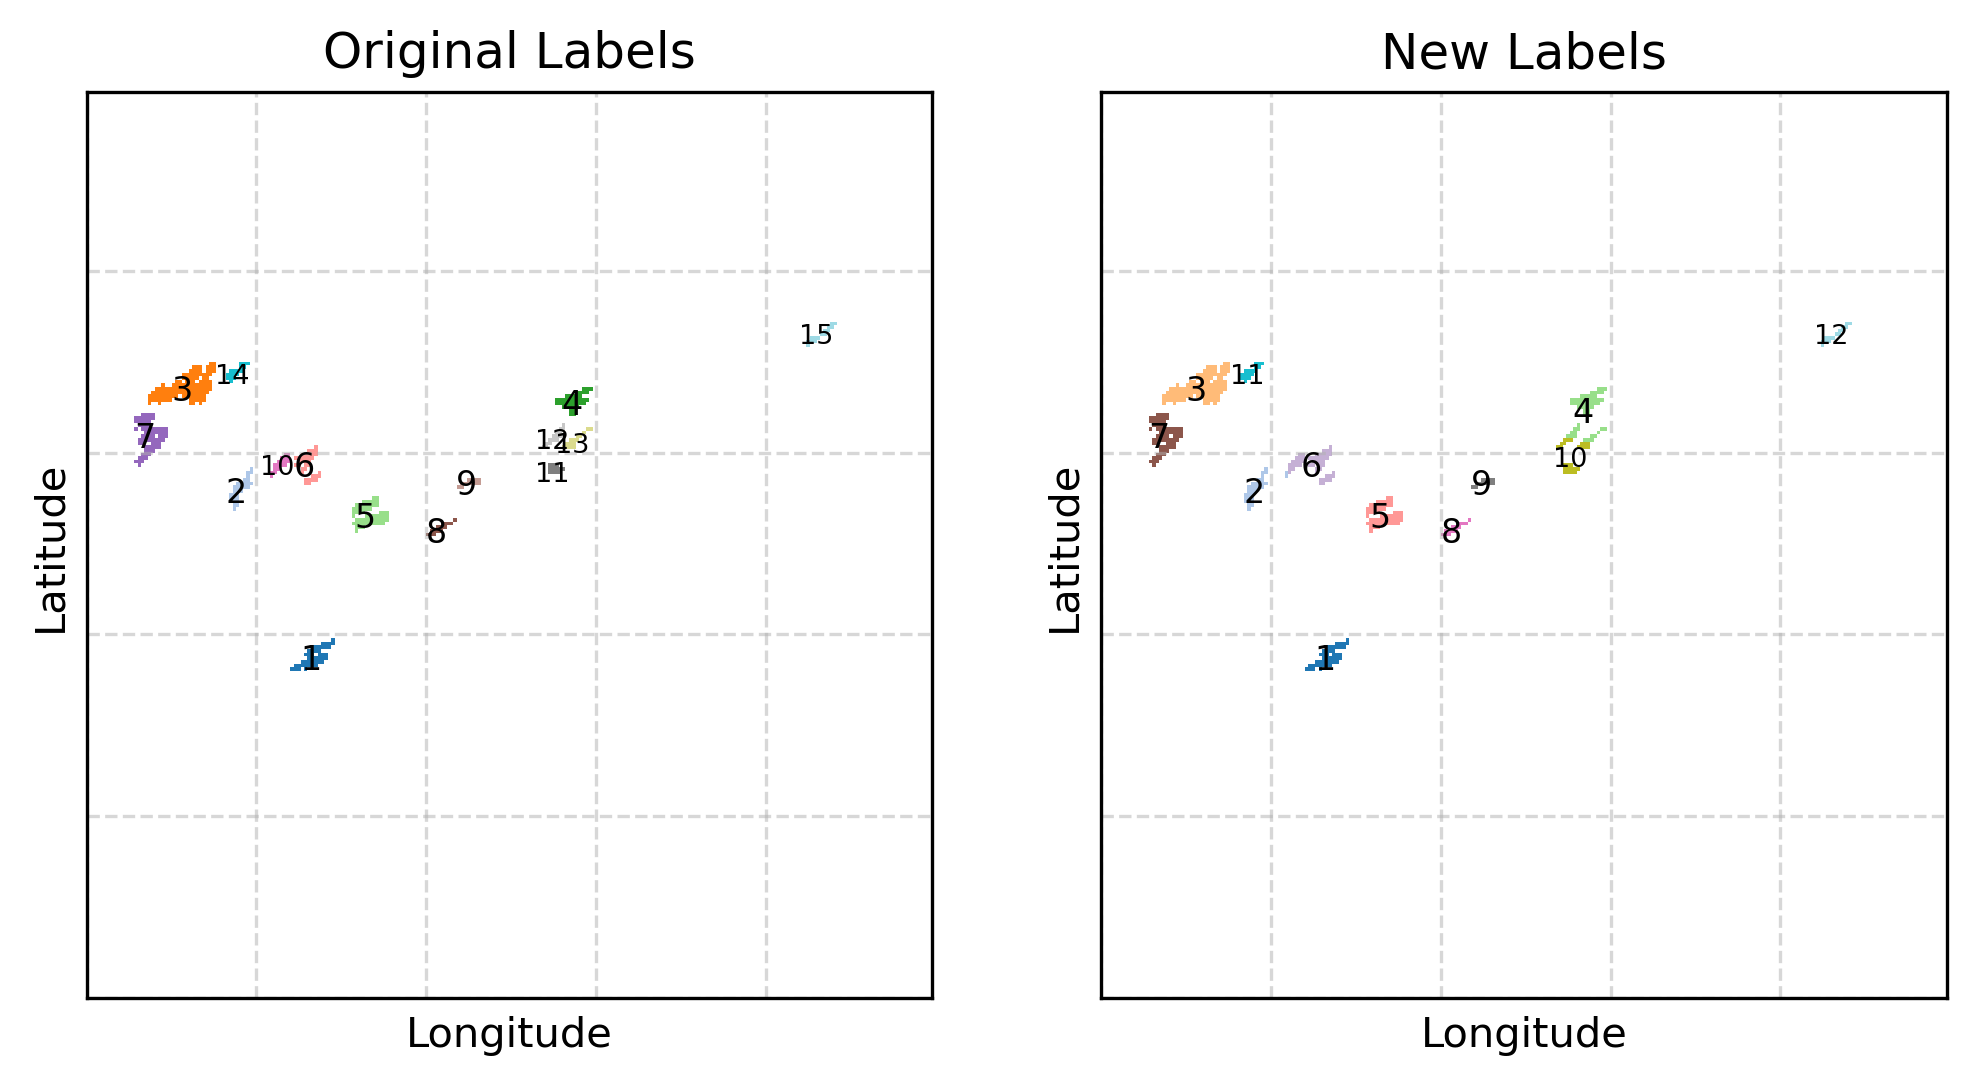

In [8]:
fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(8,4))

axes[0].set_title('Original Labels')
monte_python.plot_storm_labels(x, y, mask(old_labels), old_props, ax=axes[0])
axes[1].set_title('New Labels')
monte_python.plot_storm_labels(x, y, mask(labels), props, ax=axes[1])

In [9]:
def similarity_measure(lab1, lab2):
    i=0
    N = len(np.unique(lab1)[1:])
    for l in np.unique(lab1)[1:]:
        vals = [v for v in list(np.unique(lab2[lab1==l])) if v > 0]
        print(l, vals)
        if len(vals) > 1:
            i+=1
    print(i/N)

In [10]:
def quantize_wofs_probabilities(ensemble_probabilities):
    """
    Quantize the discrete WOFS probabilities
    """
    q_data = np.round(100.*ensemble_probabilities)
    for i, value in enumerate(np.unique(q_data)):
        q_data[q_data==value] = i
    return q_data

In [11]:
#input_data = quantize_wofs_probabilities(ensemble_probabilities)
param_set = [{'min_thresh': 0,
          'max_thresh': 18,
          'data_increment': 1,
          'delta': 0,
          'area_threshold': 400,
          'dist_btw_objects': 15 },

          {'min_thresh': 5,
          'max_thresh': 18,
          'data_increment': 1,
          'delta': 0,
          'area_threshold': 300,
          'dist_btw_objects': 25 }
            ]

In [12]:
new_path = path.replace('ENSEMBLETRACKS', '30M')
new_ds = xr.load_dataset(new_path)
data_to_label = new_ds['w_up'].values

In [13]:
method = 'single_threshold'
params = {'bdry_thresh' : 10.}
qc_params = [('min_area',10.)]

ens_object_labels = identify_deterministic_tracks(data_to_label, method, params, qc_params)

# Compute the ensemble probabilites
ens_objects_labels_binarized = np.where(ens_object_labels > 0, 1, 0)
ensemble_probabilities = np.average(ens_objects_labels_binarized, axis=0)
   
input_quantized = monte_python.object_identification.quantize_probabilities(np.copy(ensemble_probabilities),
                                                                            ensemble_size=18)
params = {'params': param_set }
new_labels = monte_python.object_identification.label(
        input_data = input_quantized, 
        method ='iterative_watershed',
        params=params,
        return_object_properties=False,
)

new_props = regionprops(new_labels, new_labels)

<AxesSubplot:title={'center':'New Labels'}, xlabel='Longitude', ylabel='Latitude'>

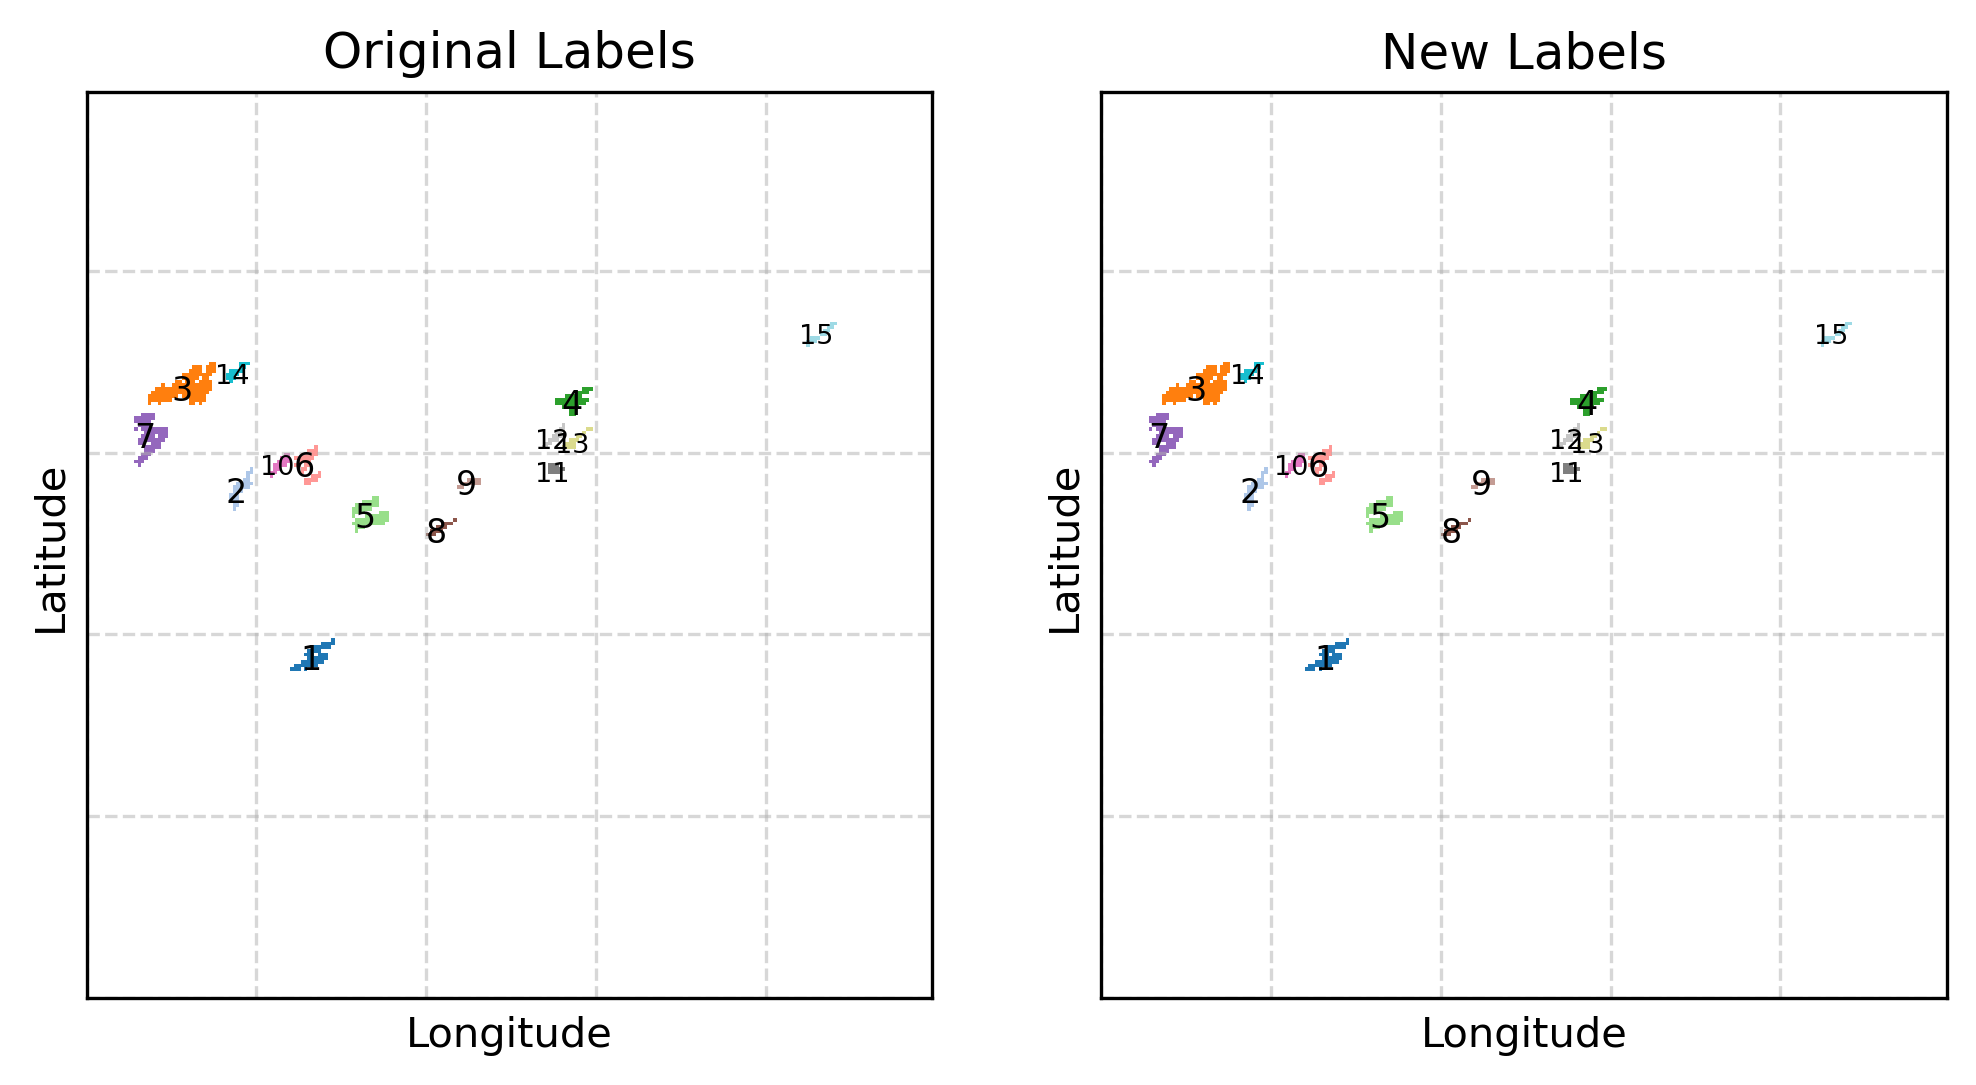

In [14]:
fig, axes = plt.subplots(dpi=300, ncols=2, figsize=(8,4))

axes[0].set_title('Original Labels')
monte_python.plot_storm_labels(x, y, mask(old_labels), old_props, ax=axes[0])
axes[1].set_title('New Labels')
monte_python.plot_storm_labels(x, y, mask(new_labels), new_props, ax=axes[1])